In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
from torch.utils.data import  DataLoader
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset, pickle_write, pickle_read
from dataset.normalization import  ZeroMinMax
from dataset.station_dataset import GroundstationDataset
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.LightningModule import LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_scatter
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
from multiprocessing.pool import ThreadPool
from itertools import repeat
plt.rcParams['text.usetex'] = False

FIGSIZE=(13.33,7.5)
DPI=300

In [3]:


config = {
    "batch_size": 10000,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI",], # 'sat_SZA', 'sat_AZI', 'coscatter_angle'],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
}
config = SimpleNamespace(**config)



In [4]:
# estimator = LitEstimator()
trainer = Trainer(
    accelerator="cpu",
    devices=1,
    precision="16",
)



# # chkpt_fn = "../train/SIS_point_estimation/vh232f2j/checkpoints/epoch=11-step=11928.ckpt"
# # chkpt_fn = '../train/SIS_point_estimation/wv1ykh5d/checkpoints/epoch=8-step=8946.ckpt' # SARAH3 emulator
# # chkpt_fn = '../train/SIS_point_estimation_groundstation/1otg6d0w/checkpoints/epoch=3-val_loss=0.01542.ckpt' # trained on 80 DWD groundstations
# # chkpt_fn = '../train/SIS_point_estimation_groundstation/4krccmyz/checkpoints/epoch=0-val_loss=0.09168.ckpt' # retrained for bias on SARAH3


# chkpt_fn = '../train/SIS_point_estimation/4nbyae30/checkpoints/epoch=7-val_loss=0.01023.ckpt'# SARAH3 emulator
# # chkpt_fn = '../train/SIS_point_estimation_groundstation/pl86of1b/checkpoints/epoch=4-val_loss=0.01630.ckpt' # finetuned on 80 DWD groundstations
# # chkpt_fn = '../train/SIS_point_estimation_groundstation/groundstations_only/checkpoints/epoch=10-val_loss=0.01703.ckpt' # trained only on 80 DWD groundstations
# # chkpt_fn = '../train/SIS_point_estimation_groundstation/ld18qnr7/checkpoints/epoch=19-step=14020.ckpt'# Finetuned for 19 epoch but with parameter loss
# # chkpt_fn = '../train/SIS_point_estimation_groundstation/mps1bagn/checkpoints/epoch=0-val_loss=0.01839.ckpt' # finetuned for 1 epoch with parameter loss
# # chkpt_fn = '../train/SIS_point_estimation_groundstation/wu24vik3/checkpoints/epoch=8-val_loss=0.01883.ckpt' # finetuned on BSRN
# # chkpt_fn = '../train/SIS_point_estimation_groundstation/ulw5nuu8/checkpoints/epoch=0-val_loss=0.01874.ckpt' # finetuned for 9 epoch DWD with high parameter loss
# chkpt_fn = '../train/SIS_point_estimation_groundstation/drvowqn4/checkpoints/epoch=0-val_loss=0.01659.ckpt' # finetuned DWD, freeze MLP

# Emulator 
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/9souphz8/checkpoints/epoch=0-val_loss=0.00698.ckpt'
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/jup3gn3n/checkpoints/epoch=1-val_loss=0.00705.ckpt'

# finetuned
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/hmobjerd/checkpoints/epoch=1-bsrnval_loss/dataloader_idx_1=0.01771-dwdval_loss/dataloader_idx_0=0.01761.ckpt'
# DWD -> METEOSWISS
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/4j9y9tqb/checkpoints/epoch=3-bsrnval_loss/dataloader_idx_1=0.01907-dwdval_loss/dataloader_idx_0=0.01901.ckpt'
# DWD -> meteoswiss -> bsrn 
chkpt_fn = '../04_results/irradiance_estimation/train/SIS_point_estimation_groundstation/hg90jzjy/checkpoints/epoch=1-bsrnval_loss/dataloader_idx_1=0.01735-dwdval_loss/dataloader_idx_0=0.01794-meteoval_loss/dataloader_idx_2=0.02489.ckpt'

# groundstations only
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/6zy2qu70/checkpoints/last.ckpt'


#### TEST coscatterangle 
# coscatter dwd
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation//train/SIS_point_estimation_groundstation/2oys35k3/checkpoints/epoch=6-step=14469.ckpt' # finetuned DWD, freeze MLP
# coscatter bsrn
# chkpt_fn = '/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/xqklgx75/checkpoints/epoch=6-step=1274.ckpt'



inference_fn = chkpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)
    os.mkdir(inference_fn + 'IEA_PVPS/')
    os.mkdir(inference_fn + 'METEOSWISS/')
    os.mkdir(inference_fn + 'DWD_valid/')
    os.mkdir(inference_fn + 'DWD_train/')
    os.mkdir(inference_fn + 'KNMI/')

if not os.path.exists(inference_fn + 'DWD_valid/'):
    os.mkdir(inference_fn + 'DWD_valid/')
    os.mkdir(inference_fn + 'DWD_train/')
    
estimator = LitEstimatorPoint.load_from_checkpoint(
    chkpt_fn,
    learning_rate=0.001,
    config=config,
)
print(chkpt_fn)

/home/kr/.local/lib/python3.10/site-packages/lightning/fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/home/kr/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:552: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


../04_results/irradiance_estimation/train/SIS_point_estimation_groundstation/hg90jzjy/checkpoints/epoch=1-bsrnval_loss/dataloader_idx_1=0.01735-dwdval_loss/dataloader_idx_0=0.01794-meteoval_loss/dataloader_idx_2=0.02489.ckpt


/home/kr/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/kr/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


In [42]:
from dataset.dataset import ForecastingDataset


estimator.eval()

dataset= ForecastingDataset(
        y_vars=config.y_vars,
        x_vars=config.x_vars,
        x_features=config.x_features,
        patch_size=config.patch_size,
        transform=config.transform,
        target_transform=config.target_transform,
        subset_time=slice('2022-07-08T11', '2022-07-08T14')
    )

W = dataset.W - dataset.pad*2
H = dataset.H - dataset.pad*2

predict_dataloader = DataLoader(dataset, batch_size=None, shuffle=False, num_workers=6,)

SIS_pred = np.zeros((len(dataset.seviri.time), W, H))
SIS_CLS = np.zeros((len(dataset.seviri.time), W, H))

for batch_idx, batch in tqdm(enumerate(predict_dataloader), total=len(predict_dataloader)):
    X, x, ghi_cls = batch
    y_hat, _,_, = estimator.predict_step((X, x, 0))
    y_hat = config.target_transform.inverse(y_hat, config.y_vars)
    y_hat = y_hat.detach().numpy()

    idx_x, idx_y, idx_t = dataset.get_indices(batch_idx)
    SIS_pred[:, idx_x, idx_y] = y_hat.squeeze()
    SIS_CLS[:, idx_x, idx_y] = ghi_cls.squeeze()


100%|██████████| 42036/42036 [33:57<00:00, 20.64it/s]  


In [48]:
dataset.seviri.isel(lat=slice(dataset.pad, -dataset.pad), lon=slice(dataset.pad, -dataset.pad))

<xarray.Dataset>
Dimensions:       (channel: 11, time: 16, lat: 186, lon: 226)
Coordinates:
  * channel       (channel) <U10 'channel_3' 'channel_4' ... 'channel_6'
    crs           <U740 ...
    spatial_ref   int64 ...
  * time          (time) datetime64[ns] 2022-07-08T11:00:00 ... 2022-07-08T14...
  * lon           (lon) float64 7.375 7.425 7.475 7.525 ... 18.52 18.58 18.62
  * lat           (lat) float64 37.38 37.43 37.48 37.53 ... 46.53 46.58 46.62
Data variables:
    channel_data  (channel, time, lat, lon) float16 dask.array<chunksize=(11, 1, 186, 226), meta=np.ndarray>

In [51]:
output = xarray.Dataset(
    {
        "SIS": (("time", "lon", "lat"), SIS_pred),
        "SIS_CLS": (("time", "lon", "lat"), SIS_CLS),
    },
    coords={
        "time": dataset.seviri.time,
        "lat": dataset.seviri.lat.isel(lat=slice(dataset.pad, -dataset.pad)),
        "lon": dataset.seviri.lon.isel(lon=slice(dataset.pad, -dataset.pad)),
    },
)


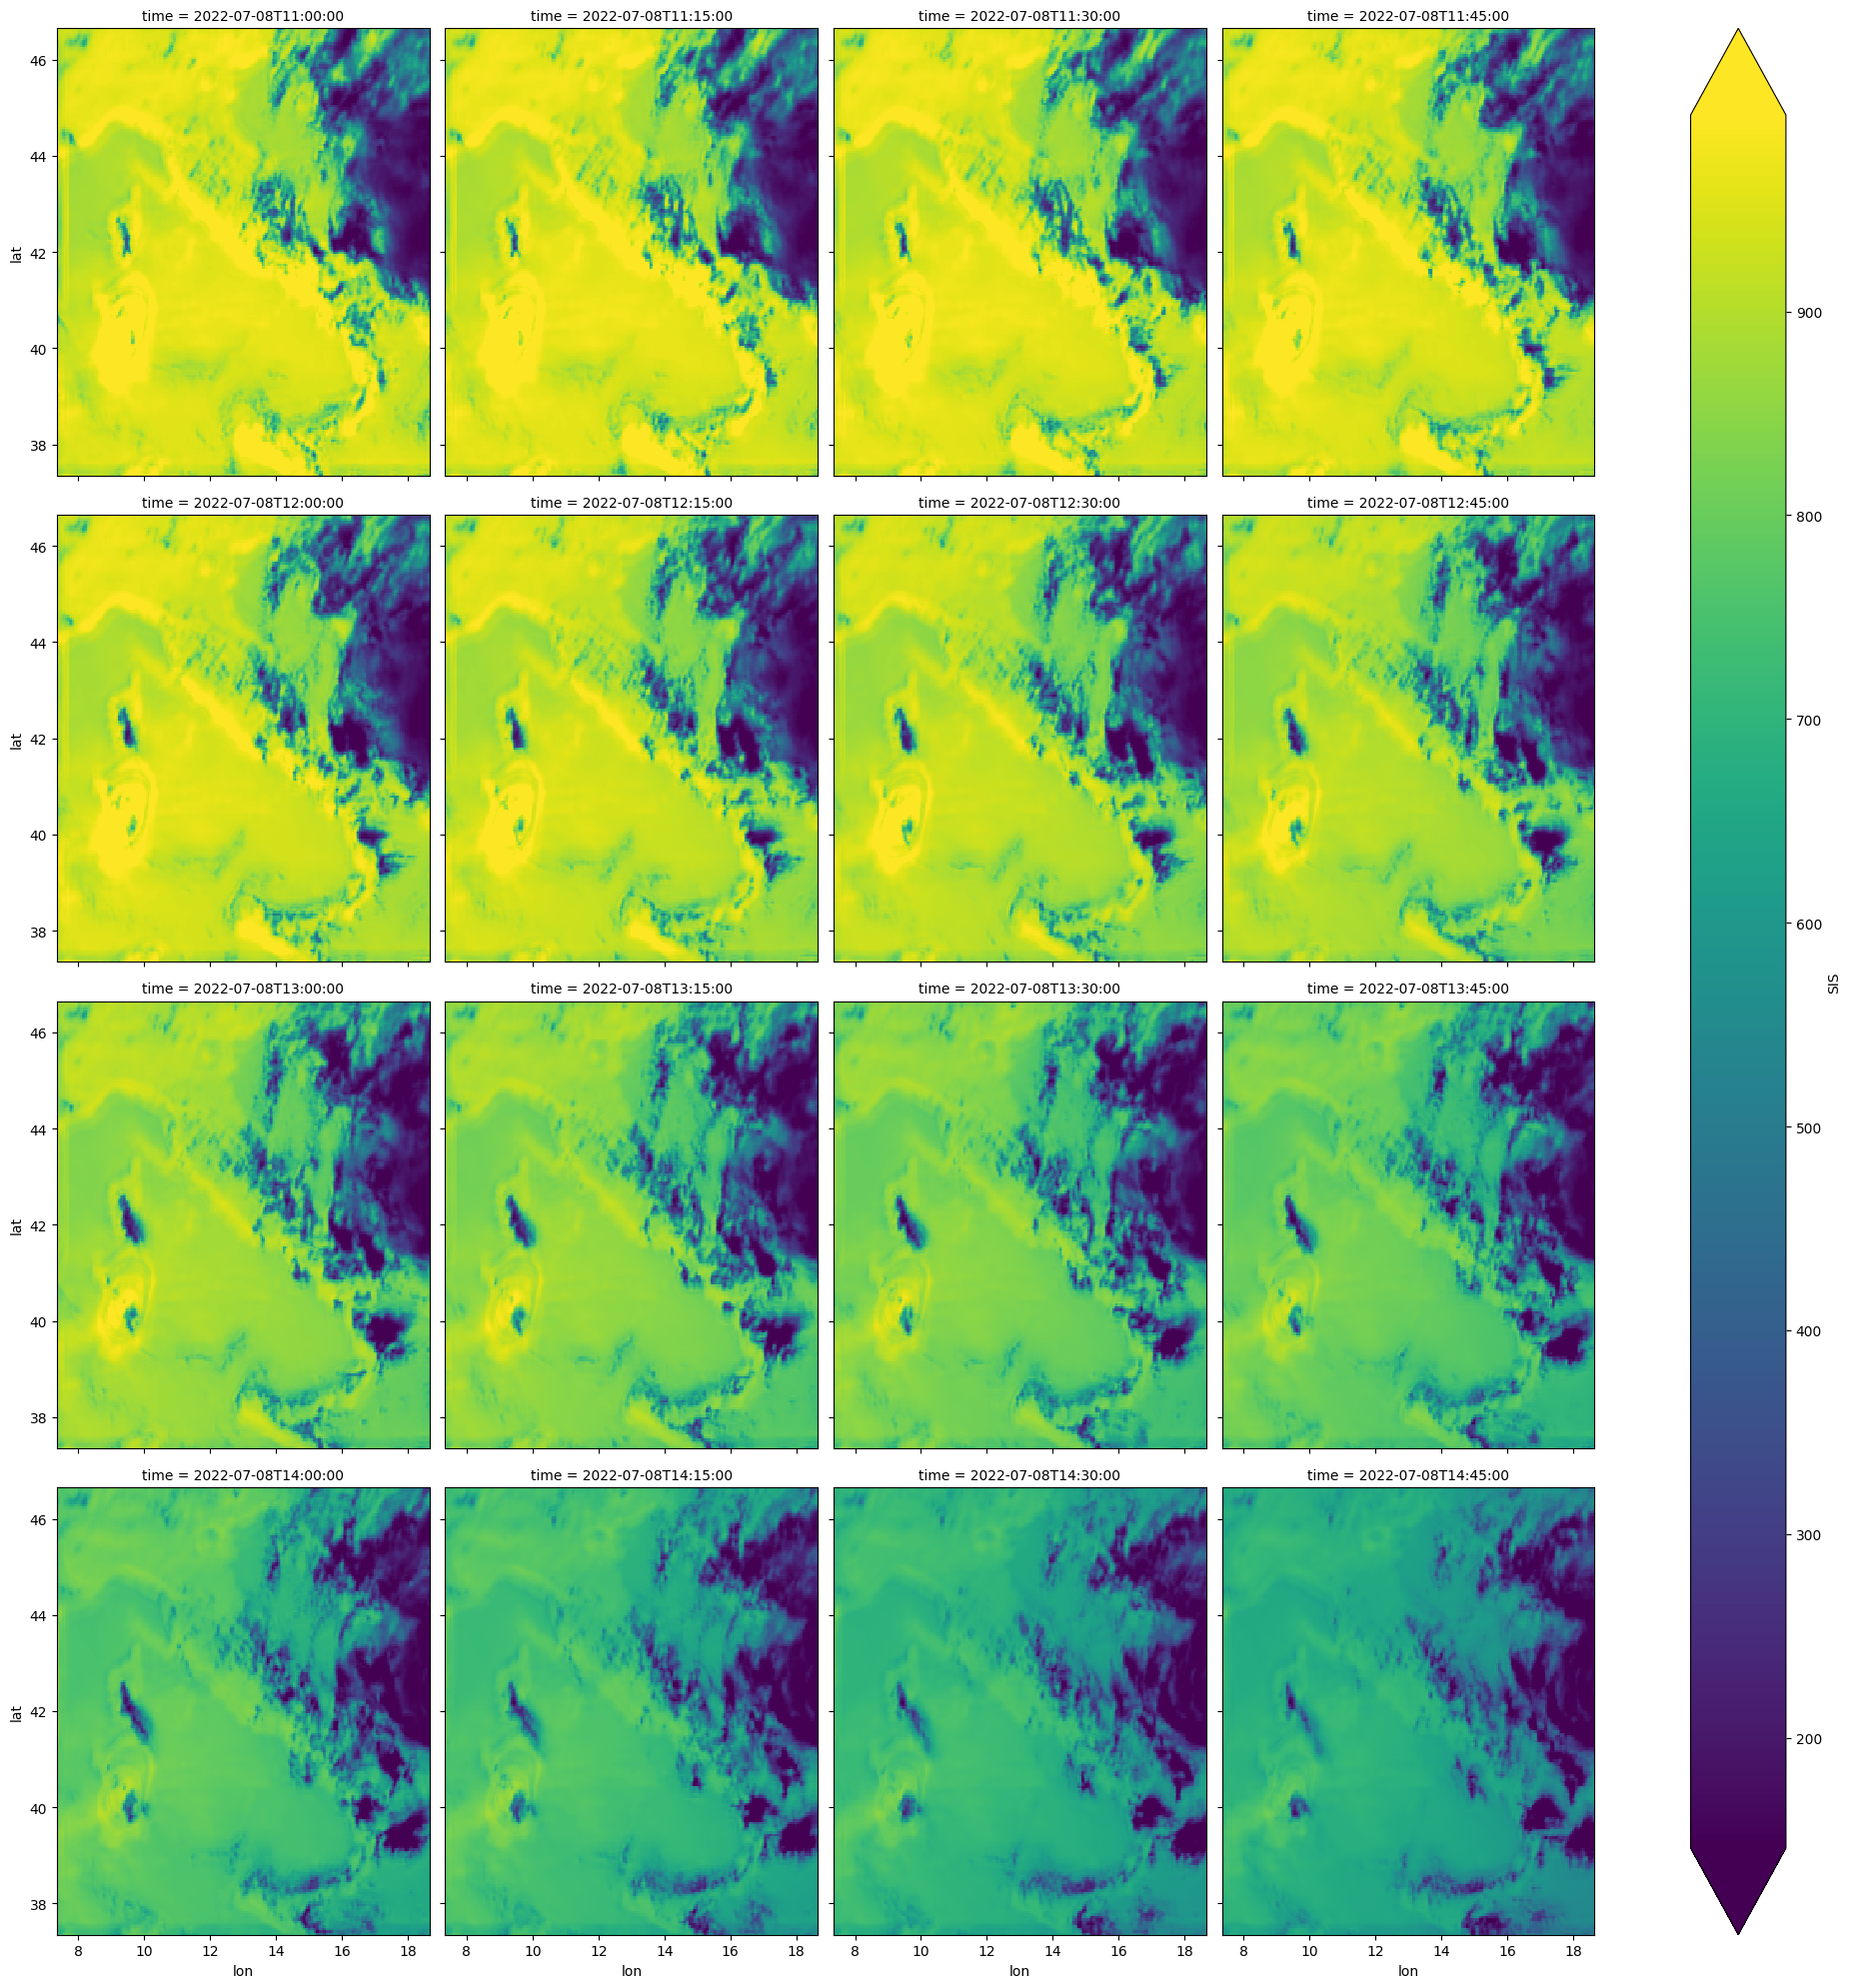

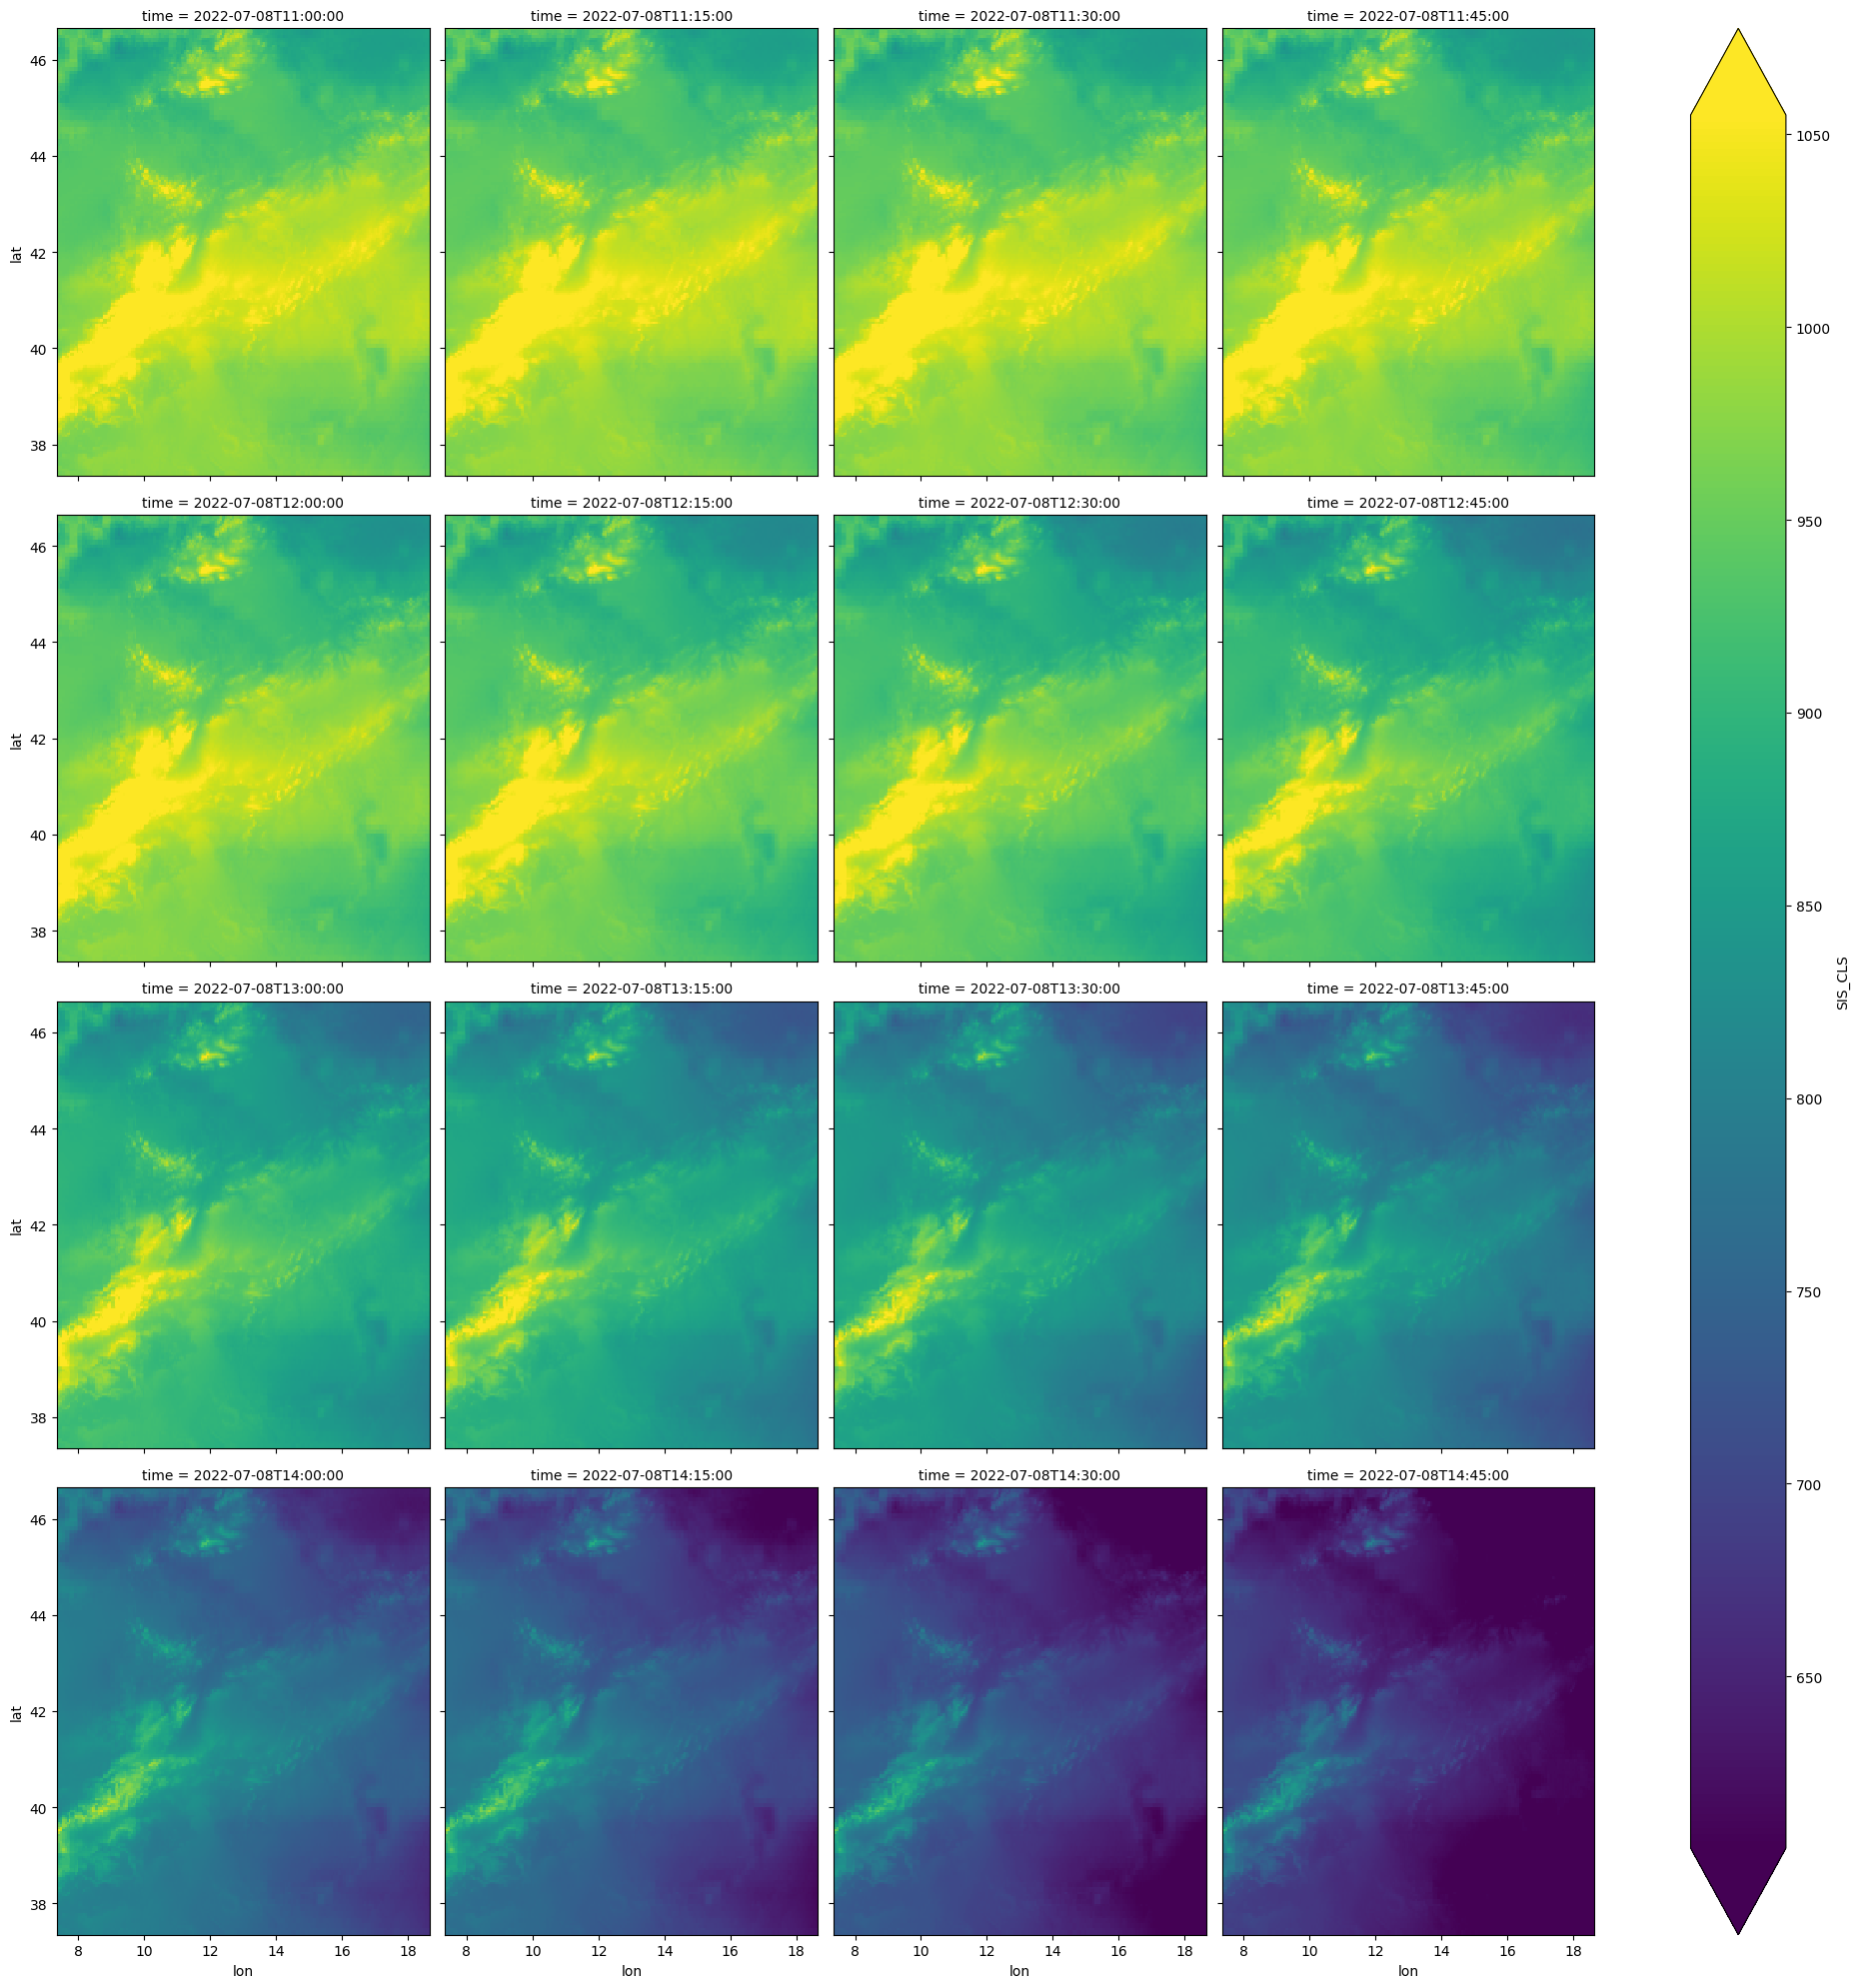

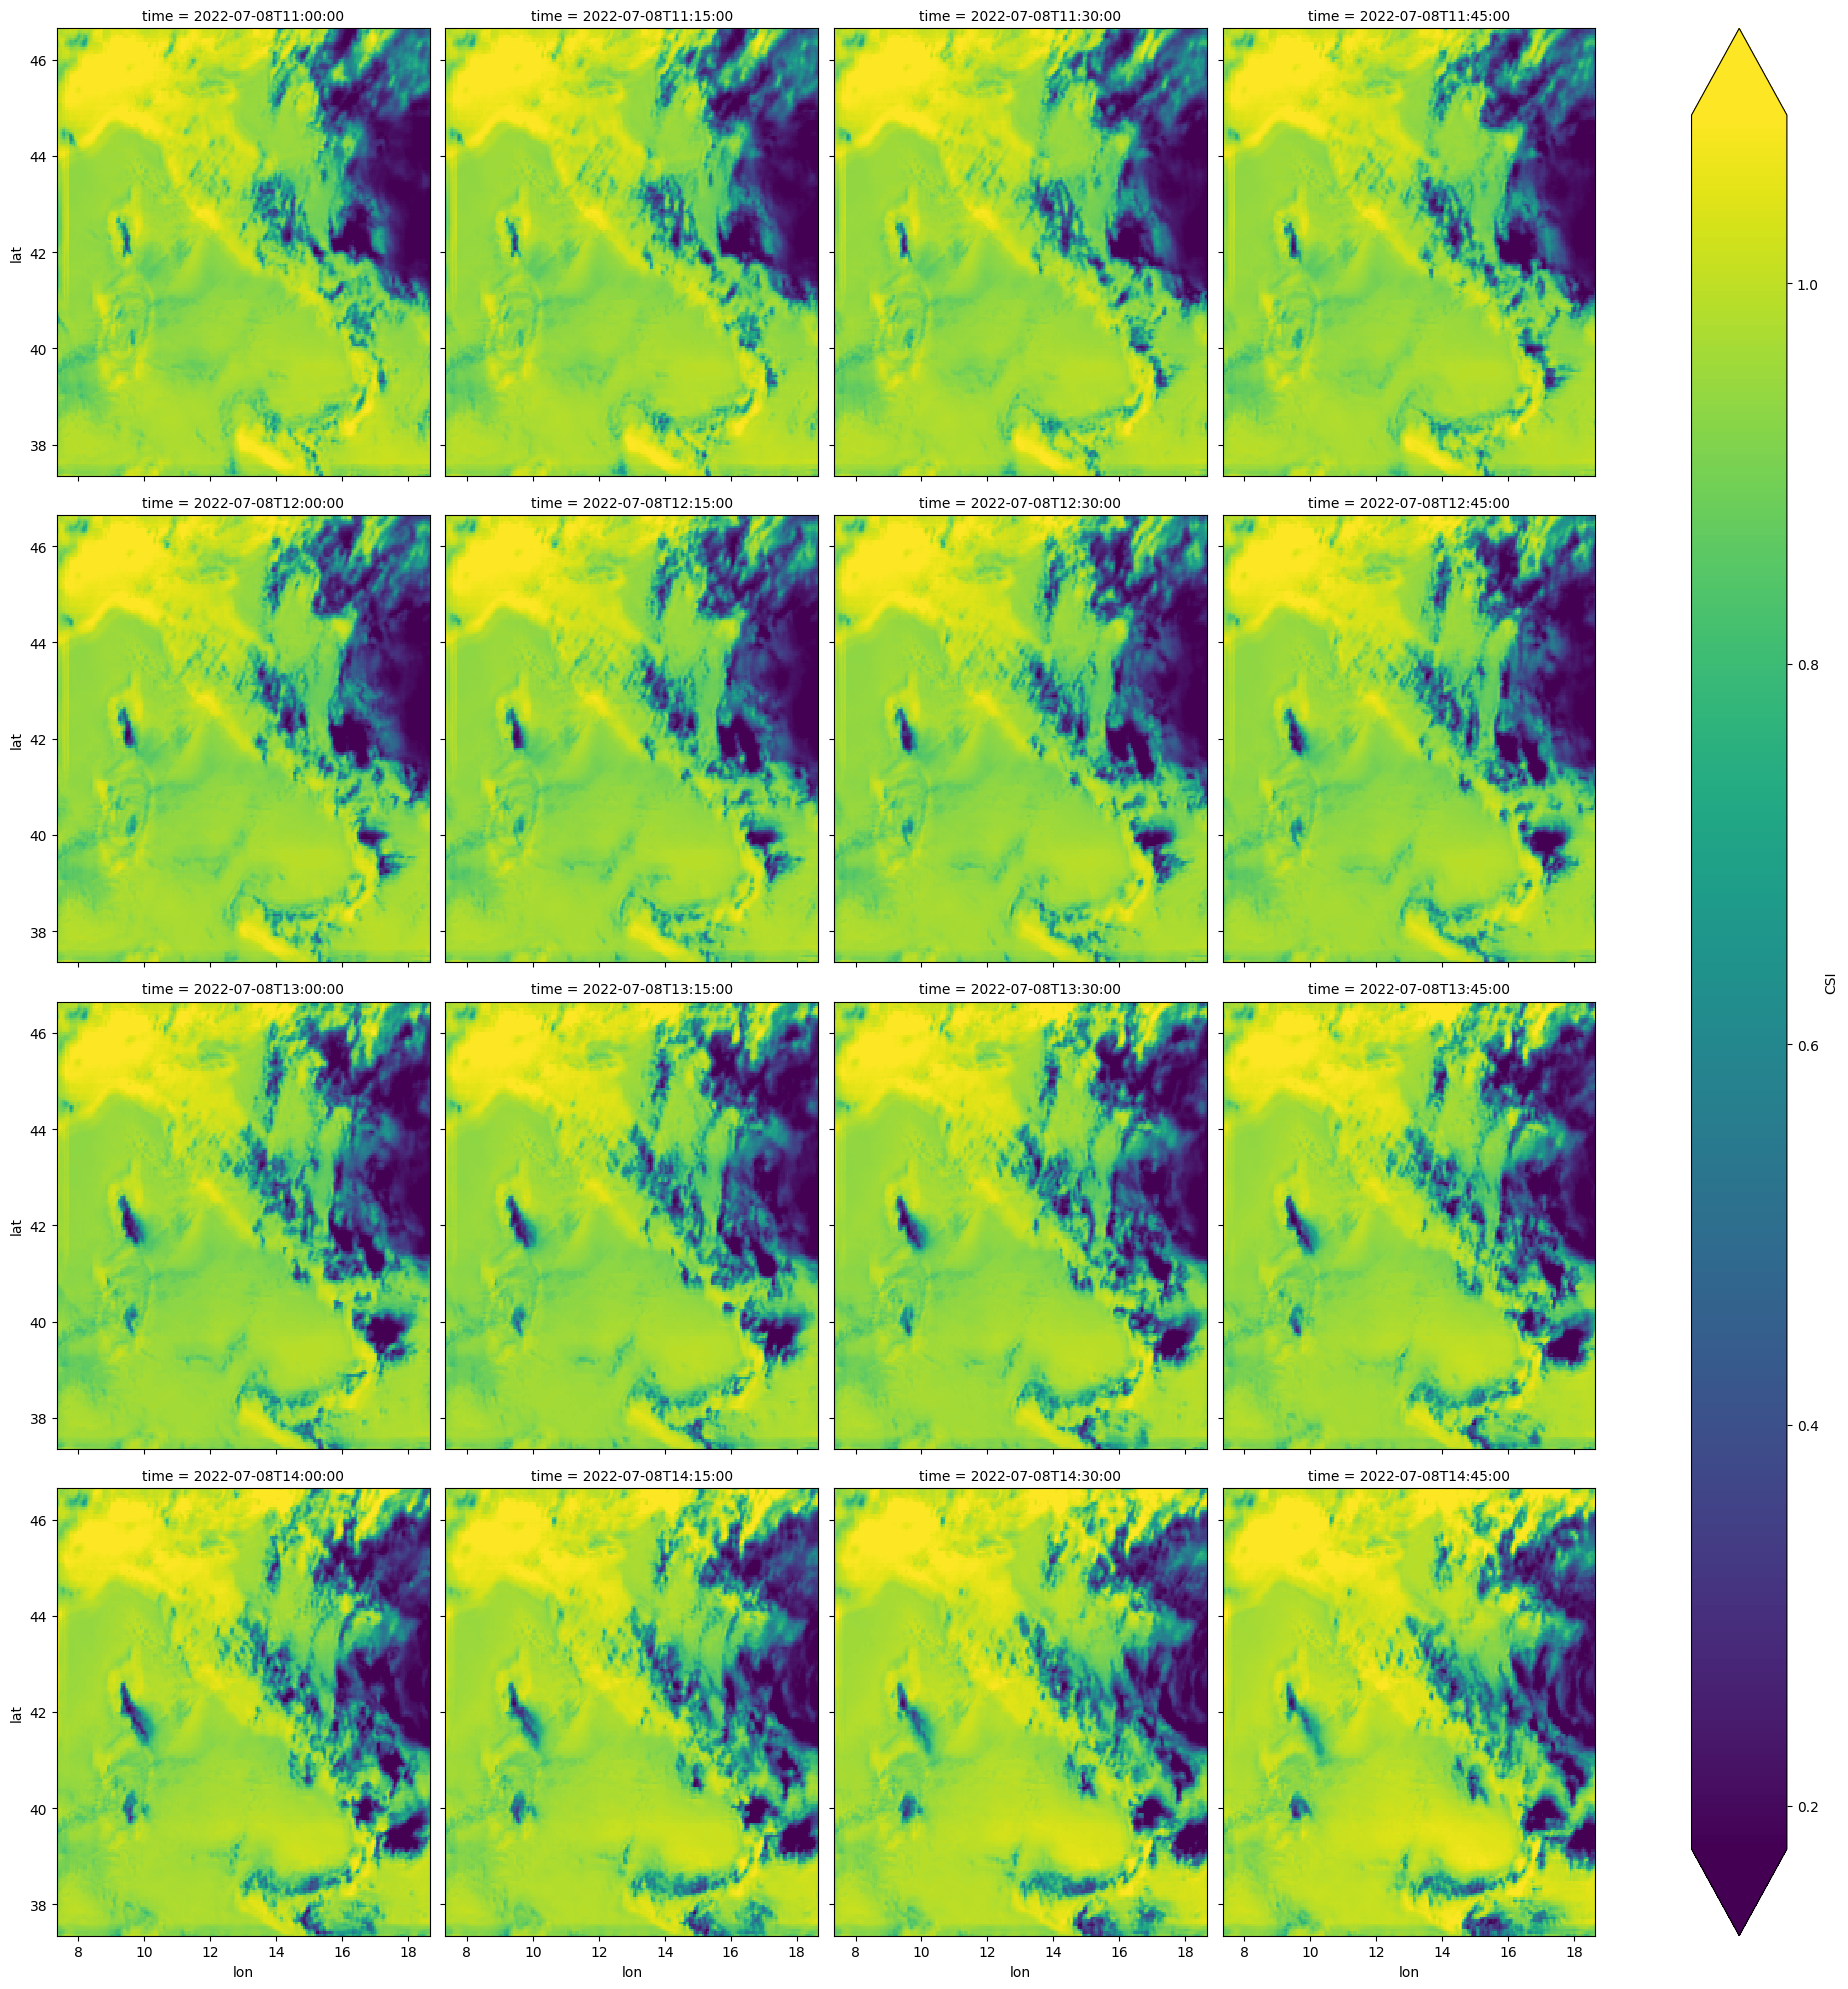

In [56]:
output.SIS.plot.imshow(
    x="lon",
    y="lat",
    col="time",
    col_wrap=4,
    cmap="viridis",
    robust=True,
    figsize=(20, 20),
)
output.SIS_CLS.plot.imshow( 
    x="lon",
    y="lat",
    col="time",
    col_wrap=4,
    cmap="viridis",
    robust=True,
    figsize=(20, 20),
)

output['CSI']= output.SIS/output.SIS_CLS

output.CSI.plot.imshow( 
    x="lon",
    y="lat",
    col="time",
    col_wrap=4,
    cmap="viridis",
    robust=True,
    figsize=(20, 20),
)

output.to_netcdf('test_forecast.nc')